In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [3]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $\sigma$ and $D$ for underlying $p_{\rm eq}$

In [4]:
D = 500; # Diffusion coefficient
sigma_kref = 8.

kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

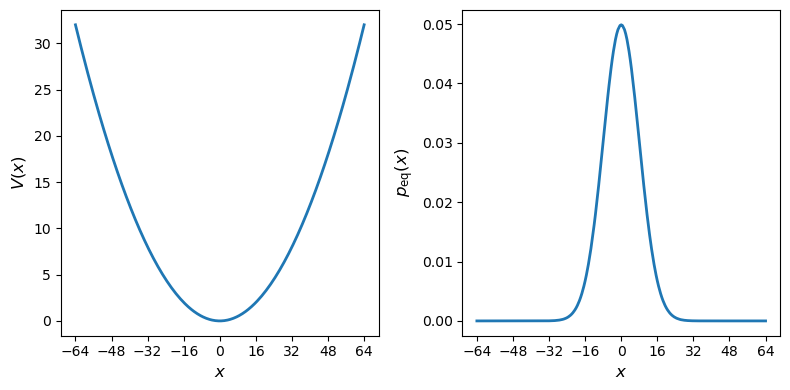

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 3: Read Trajectory

#### physical parameters about simulations

In [5]:
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [6]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
p_eq = rho_eq .* rho_eq;
D = load(f_in, "D");

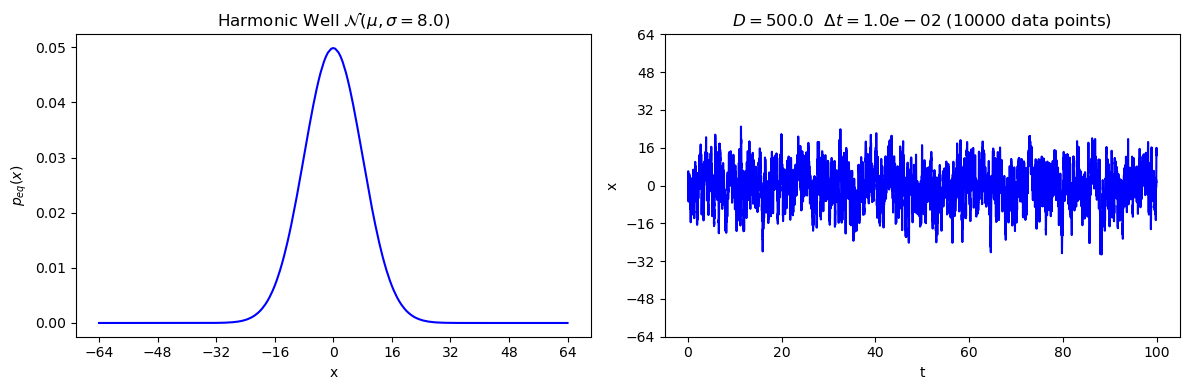

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "Harmonic Well \$ {\\mathcal {N}}(\\mu ,\\sigma=%1.1f)\$" sigma_kref)

ax = axes[2]
ax.plot(t_record, y_record, color="blue")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_yticks(-64:16:64)
ax.set_title(@sprintf "\$ D=%.1f~~\\Delta t=%.1e\$ (%d data points)" D save_freq tau)

plt.tight_layout()
plt.show()

### Part 4: Set $p_0$

In [8]:
V0 = symmetry_wall_potential.(-64., 64., 2.5, 10.0, xref)
rho_0 = get_rhoeq(V0, w0)
p0 = rho_0 .* rho_0;

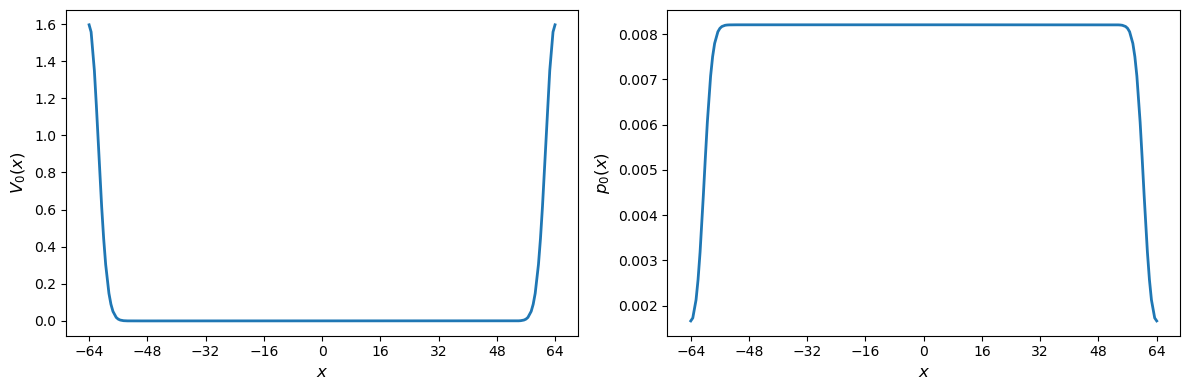

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, V0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V_0(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 5: Update $p_{\rm eq}$ by EM

In [10]:
D_array_1 = [10, 50]
D_array_2 = 100:100:900
D_array_3 = 1000:1000:4000
D_array = float(vcat(D_array_1, D_array_2, D_array_3))
last_em_id_array = zeros(length(D_array));

In [11]:
max_n_iteration = 30
sigma_photon = 0.5
d_idx = 0
for D_test in D_array
    p0 = rho_0 .* rho_0
    k_photon = get_k_by_sigma(sigma_photon)
    
    f_out_pcontain = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_photon_operator_%d.jld" d_idx
    f_out_d_record = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/D_photon_operator_%d.jld" d_idx
    f_out_l_record = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/l_photon_operator_%d.jld" d_idx
    
    p_container, D_records, log_likelihood_records, last_iter_id = complete_em_only_update_peq_given_p0(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record, k_photon, p0, D_test)
    last_em_id_array[d_idx+1] = last_iter_id
    d_idx += 1
end

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10
Iteration-ID: 11
Iteration-ID: 12
Iteration-ID: 13
Iteration-ID: 14
Iteration-ID: 15
Iteration-ID: 16
Iteration-ID: 17
Iteration-ID: 18
Iteration-ID: 19
Iteration-ID: 20
Iteration-ID: 21
Iteration-ID: 22
Iteration-ID: 23
Iteration-ID: 24
Iteration-ID: 25
Iteration-ID: 26
Iteration-ID: 27
Iteration-ID: 28
Iteration-ID: 29
Iteration-ID: 30
The number of iteration exceeds the setting maximum number!
Write p_container to /home/yizaochen/codes/julia/md_pisl/EM_data/peq_photon_operator_0.jld
Write D_records to /home/yizaochen/codes/julia/md_pisl/EM_data/D_photon_operator_0.jld
Write log_likelihood_records to /home/yizaochen/codes/julia/md_pisl/EM_data/l_photon_operator_0.jld
Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Iteration-ID: 7
Iteration-ID: 8
Iteration-ID: 9
Iteration-ID: 10


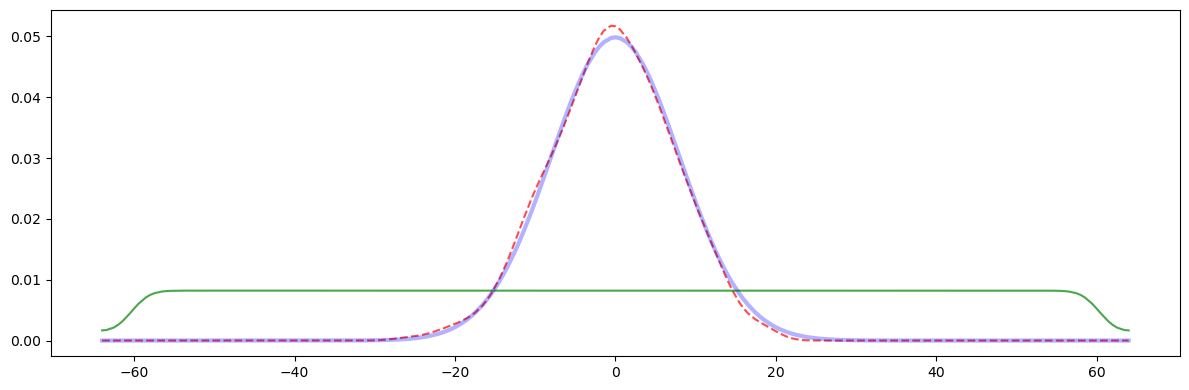

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

lastem_id = 3
sigma_idx = 5
f_in_pcontain = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_photon_operator_%d.jld" sigma_idx
p_container = load(f_in_pcontain, "p_container");
        
ax.plot(xref, p_container[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
ax.plot(xref, p_container[1,:], label="\$ p_0(x) \$:KDE", alpha=0.7, color="green")
ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/D_scan_0.svg")
plt.show()

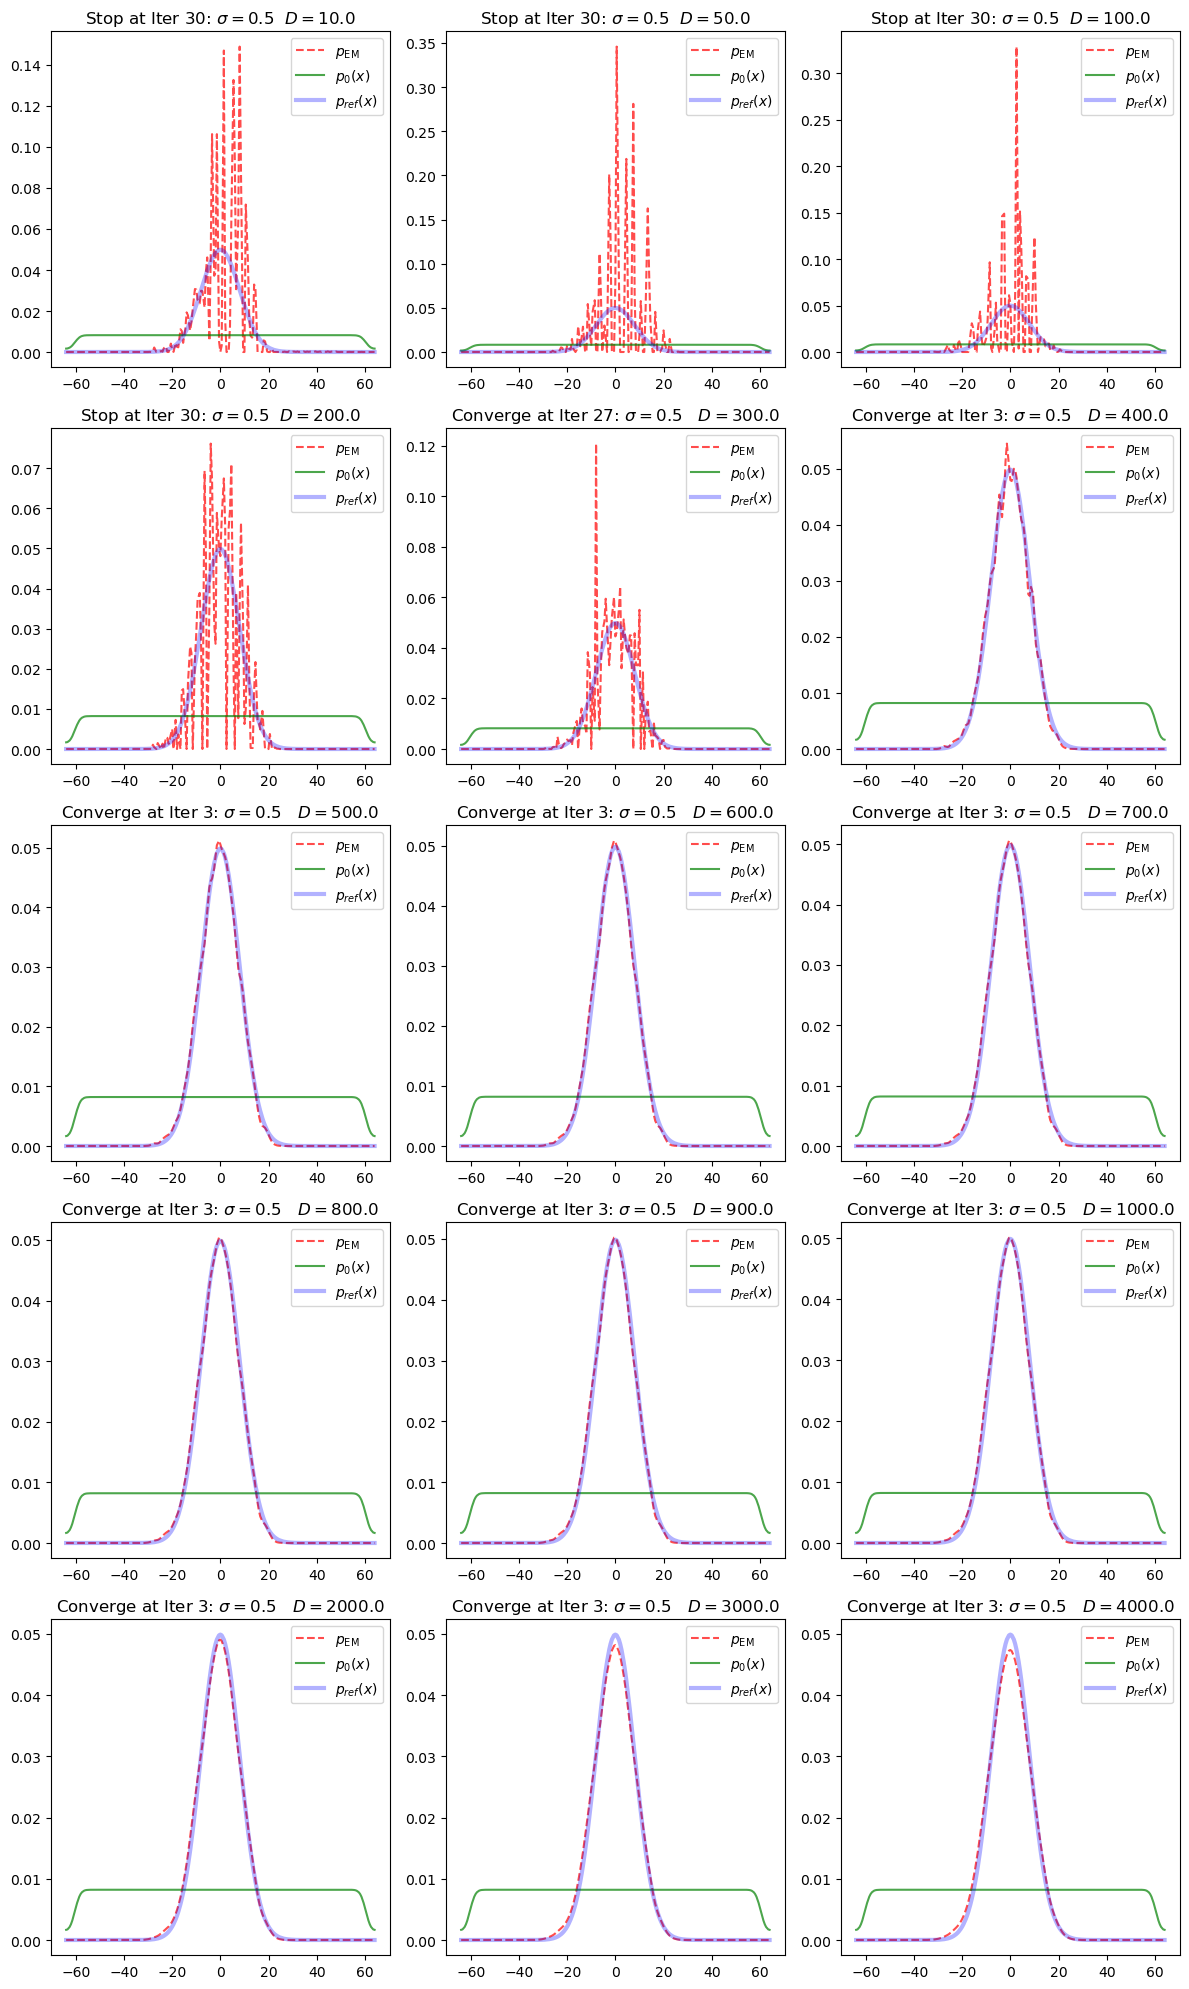

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 20))

d_idx = 0
for row_id=1:5
    for col_id=1:3
        lastem_id = Int(last_em_id_array[d_idx+1])
        D_test = D_array[d_idx+1]
        f_in_pcontain = @sprintf "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_photon_operator_%d.jld" d_idx
        p_container = load(f_in_pcontain, "p_container");
        
        ax = axes[row_id, col_id]
        ax.plot(xref, p_container[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{\\rm EM}\$")
        ax.plot(xref, p_container[1,:], label="\$ p_0(x) \$", alpha=0.7, color="green")
        ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
        ax.legend()
        
        if lastem_id == 30
            ax.set_title(@sprintf "Stop at Iter 30: \$\\sigma=%1.1f\$  \$D=%1.1f\$" sigma_photon D_test)
        else
            ax.set_title(@sprintf "Converge at Iter %d: \$\\sigma=%1.1f\$   \$D=%1.1f\$" lastem_id sigma_photon D_test)
        end
        
        d_idx += 1
    end
end

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/0/photon_operator_Dtest_for_peq.pdf")
plt.show()